<a href="https://colab.research.google.com/github/Kerriea-star/time-series-forecasting-with-lstm-autoencoders/blob/main/Time_Series_Forecasting_with_LSTM_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   The purpose of this work is to show one way time-series data can be effiently encoded to lower dimensions, to be used into non time-series models.
*   Here I'll encode a time-series of size 12 (12 months) to a single value and use it on a MLP deep learning model, instead of using the time-series on a LSTM model that could be the regular approach.

**Predict future sales**

The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

**Data fields description:**

*   ID - an Id that represents a (Shop, Item) tuple within the test set
*   shop_id - unique identifier of a shop
*   item_id - unique identifier of a product
*   item_category_id - unique identifier of item category
*   date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
*   date - date in format dd/mm/yyyy
*   item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
*   item_price - current price of an item
*   item_name - name of item
*   shop_name - name of shop
*   item_category_name - name of item category



In [25]:
# Dependencies
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.layers as L

from keras import optimizers, Sequential, Model



In [26]:
# Set seeds to make the experiment more reproducible
def seed_everything(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [27]:
# Loading data
test = pd.read_csv("drive/MyDrive/Colab Notebooks/time-series-forecasting-with-lstm-autoencoders/data/test.csv", dtype={"ID": 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
item_categories = pd.read_csv("drive/MyDrive/Colab Notebooks/time-series-forecasting-with-lstm-autoencoders/data/test.csv", dtype={'item_category': 'str', 'item_category_id': 'int32'})
items = pd.read_csv("drive/MyDrive/Colab Notebooks/time-series-forecasting-with-lstm-autoencoders/data/items.csv", dtype={"item_name": 'str', 'item_id': 'int32'})
shops = pd.read_csv("drive/MyDrive/Colab Notebooks/time-series-forecasting-with-lstm-autoencoders/data/shops.csv", dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv("drive/MyDrive/Colab Notebooks/time-series-forecasting-with-lstm-autoencoders/data/sales_train.csv", parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32',
                                                                                                                                                 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})


In [28]:
# Join data sets
train = sales.join(items, on="item_id", rsuffix='_').join(shops, on="shop_id", rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(["item_id_", "shop_id_", "item_category_id"], axis=1)


In [29]:
# Let's look at the raw data
print(f"Train rows: {train.shape[0]}")
print(f"Train columns: {train.shape[1]}")

display(train.head())
display(train.describe())

Train rows: 2935849
Train columns: 9


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,shop_name,ID
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),"Ярославль ТЦ ""Альтаир""",37
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,"Москва ТРК ""Атриум""",58
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,"Москва ТРК ""Атриум""",58
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,"Москва ТРК ""Атриум""",58
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),"Москва ТРК ""Атриум""",56


,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [30]:
# Time period of the dataset
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [31]:
# Leave only the "shop_id" and "item_id" that exist in the test set to have more accurate results
test_shop_ids = test["shop_id"].unique()
test_item_ids = test["item_id"].unique()

# Only shops that exist in test set.
train = train[train["shop_id"].isin(test_shop_ids)]

# Only items that exist in test set.
train = train[train["item_id"].isin(test_item_ids)]

**Data Preprocessing**

*   Drop all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
*   We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month
*   Leave only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.



In [32]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day': ['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')

# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10))
display(train_monthly.describe())

,date_block_num,shop_id,item_id,item_cnt,item_cnt_month
0,0,2,33,1,2.00
1,0,2,482,1,1.00
2,0,2,491,1,1.00
3,0,2,839,1,1.00
4,0,2,1007,3,1.00
5,0,2,1010,1,1.00
6,0,2,1023,2,1.00
7,0,2,1204,1,NaN
8,0,2,1224,1,NaN
9,0,2,1247,1,NaN


,date_block_num,shop_id,item_id,item_cnt,item_cnt_month
count,593829.00,593829.00,593829.00,593829.00,482536.00
mean,20.18,32.07,10015.02,2.10,2.07
std,9.14,16.90,6181.82,2.31,2.17
min,0.00,2.00,30.00,0.00,0.00
25%,13.00,19.00,4418.00,1.00,1.00
50%,22.00,31.00,9171.00,1.00,1.00
75%,28.00,47.00,15334.00,2.00,2.00
max,33.00,59.00,22167.00,20.00,20.00


**Time-series processing**

*   As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
*   This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan").



In [33]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair.

In [34]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
  for month1 in range((last_month - (first_month + serie_size)) + 1):
    serie = [row["shop_id"], row["item_id"]]
    for month2 in range(serie_size + 1):
      serie.append(row[month1 + first_month + month2])
    data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [35]:
# Dropping identifier columnms as we don't need them anymore
data_series = data_series.drop(["item_id", 'shop_id'], axis=1)

**Train and Validation sets.**

In [36]:
labels = data_series["label"]
data_series.drop("label", axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)


In [37]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


**Reshape data**

*   Time-series shape (data points, time-steps, features).



In [38]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


Start with regular RNN time-series approach

**Regular LSTM model.**

In [39]:
serie_size = X_train.shape[1] # 12
n_features = X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

# adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer="adam")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12, 10)            480       
                                                                 
 lstm_9 (LSTM)               (None, 12, 6)             408       
                                                                 
 lstm_10 (LSTM)              (None, 1)                 32        
                                                                 
 dense_4 (Dense)             (None, 10)                20        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,061
Trainable params: 1,061
Non-traina

In [40]:
lstm_history = lstm_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
                              batch_size=batch,
                              epochs=epochs,
                              verbose=2)

Epoch 1/20
1566/1566 - 39s - loss: 1.2715 - val_loss: 1.1618 - 39s/epoch - 25ms/step
Epoch 2/20
1566/1566 - 31s - loss: 1.1803 - val_loss: 1.1442 - 31s/epoch - 20ms/step
Epoch 3/20
1566/1566 - 32s - loss: 1.1768 - val_loss: 1.1457 - 32s/epoch - 20ms/step
Epoch 4/20
1566/1566 - 32s - loss: 1.1684 - val_loss: 1.1471 - 32s/epoch - 20ms/step
Epoch 5/20
1566/1566 - 31s - loss: 1.1676 - val_loss: 1.1637 - 31s/epoch - 20ms/step
Epoch 6/20
1566/1566 - 30s - loss: 1.1668 - val_loss: 1.1537 - 30s/epoch - 19ms/step
Epoch 7/20
1566/1566 - 32s - loss: 1.1653 - val_loss: 1.1423 - 32s/epoch - 20ms/step
Epoch 8/20
1566/1566 - 30s - loss: 1.1646 - val_loss: 1.1510 - 30s/epoch - 19ms/step
Epoch 9/20
1566/1566 - 30s - loss: 1.1634 - val_loss: 1.1427 - 30s/epoch - 19ms/step
Epoch 10/20
1566/1566 - 30s - loss: 1.1621 - val_loss: 1.1403 - 30s/epoch - 19ms/step
Epoch 11/20
1566/1566 - 30s - loss: 1.1605 - val_loss: 1.1398 - 30s/epoch - 19ms/step
Epoch 12/20
1566/1566 - 31s - loss: 1.1604 - val_loss: 1.1456 -

**Autoencoder**

*   Now we will build an autoencoder to learn how to reconstruct the input, this way it internally learns the best way to represent the input in lower dimensions.
*   The reconstruct model is composed of an encoder and a decoder, the encoder is responsible for learning how to represent the input into lower dimensions and the decoder learns how to rebuild the smaller representations into the input again.
*   After the models is trained we can keep only the encoder part and we'll have a model that is able to do what we want.

**LSTM Autoencoder**


In [41]:
encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(1, activation='relu'))
encoder_decoder.add(L.RepeatVector(serie_size))
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

encoder_decoder.compile(loss='mse', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 12, 12)            672       
                                                                 
 lstm_12 (LSTM)              (None, 12, 6)             456       
                                                                 
 lstm_13 (LSTM)              (None, 1)                 32        
                                                                 
 repeat_vector_1 (RepeatVect  (None, 12, 1)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 12, 12)            672       
                                                                 
 lstm_15 (LSTM)              (None, 12, 6)             456       
                                                      

In [42]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train,
                                              batch_size=batch,
                                              epochs=epochs,
                                              verbose=2)

Epoch 1/20
1566/1566 - 57s - loss: 1.1259 - 57s/epoch - 36ms/step
Epoch 2/20
1566/1566 - 49s - loss: 1.0040 - 49s/epoch - 31ms/step
Epoch 3/20
1566/1566 - 49s - loss: 0.9687 - 49s/epoch - 32ms/step
Epoch 4/20
1566/1566 - 49s - loss: 0.9436 - 49s/epoch - 32ms/step
Epoch 5/20
1566/1566 - 48s - loss: 0.9124 - 48s/epoch - 30ms/step
Epoch 6/20
1566/1566 - 48s - loss: 0.8938 - 48s/epoch - 31ms/step
Epoch 7/20
1566/1566 - 51s - loss: 0.9285 - 51s/epoch - 33ms/step
Epoch 8/20
1566/1566 - 48s - loss: 0.8753 - 48s/epoch - 31ms/step
Epoch 9/20
1566/1566 - 49s - loss: 0.8574 - 49s/epoch - 31ms/step
Epoch 10/20
1566/1566 - 49s - loss: 0.8619 - 49s/epoch - 31ms/step
Epoch 11/20
1566/1566 - 50s - loss: 0.8790 - 50s/epoch - 32ms/step
Epoch 12/20
1566/1566 - 50s - loss: 0.8805 - 50s/epoch - 32ms/step
Epoch 13/20
1566/1566 - 48s - loss: 0.9021 - 48s/epoch - 30ms/step
Epoch 14/20
1566/1566 - 48s - loss: 0.8777 - 48s/epoch - 31ms/step
Epoch 15/20
1566/1566 - 51s - loss: 0.8367 - 51s/epoch - 33ms/step
Epoc

The better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.

Let's take a look at the layers of the encoder_decoder model

In [43]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

About the autoencoders layers

**LSTM**

*   This is just a regular LSTM layer, a layer that is able to receive sequence data and learn based on it, nothing much.

**RepeatVector layer**

*   Here is something we don't usually see, this layers basically repeats it's input "n" times, the reason to us it is because the last layers from the encoder part (the layer with one neuron) don't return sequences, so it does not output a sequenced data, this way we can't just add another LSTM layer after it, we need a way to turn this output into a sequence of the same time-steps of the model input, this is where "RepeatVector" layers come in.
*   Outputs of the RepeatVector layers



In [44]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print("Repeat vector output shape", rpt_vector_layer_output.shape)
print("Repeat vector output sample")
print(rpt_vector_layer_output[0])

1/1 [==============================] - 0s 449ms/step
Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]
 [0.03313876]]


This is just the same value repeated some times to match the same shape of the model input.

**Time Distributed layer**

*   Sometimes used when you want to mix RNN layers with other kind of layers.
*   We could output the model with another LSTM layer with one neuron and "return_sequences=True" parameter, but using a "TimeDistributed" layer wrapping a "Dense" layer we will have the same weights for each outputted time-step.



In [45]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print("Time distributed output shape", time_dist_layer_output.shape)
print("Time distributed output sample")
print(time_dist_layer_output[0])

1/1 [==============================] - 1s 725ms/step
Time distributed output shape (1, 12, 6)
Time distributed output sample
[[9.1343522e-02 8.8544004e-03 0.0000000e+00 3.8176257e-02 0.0000000e+00
  0.0000000e+00]
 [1.5611199e-01 1.6443709e-02 0.0000000e+00 7.8091383e-02 0.0000000e+00
  4.0493463e-03]
 [2.0408258e-01 4.2056203e-02 0.0000000e+00 1.1919017e-01 0.0000000e+00
  8.4021660e-03]
 [2.4340208e-01 5.3615946e-02 0.0000000e+00 1.5772015e-01 0.0000000e+00
  1.2606783e-02]
 [2.7206373e-01 4.0622629e-02 0.0000000e+00 1.8889965e-01 0.0000000e+00
  2.0060046e-02]
 [2.8817618e-01 1.9783989e-02 0.0000000e+00 2.1213411e-01 0.0000000e+00
  3.0110430e-02]
 [2.9531121e-01 9.3388334e-03 0.0000000e+00 2.3003334e-01 0.0000000e+00
  3.9602276e-02]
 [2.9899374e-01 4.3473314e-03 0.0000000e+00 2.4550396e-01 0.0000000e+00
  4.6405323e-02]
 [3.0113742e-01 2.0082574e-03 0.0000000e+00 2.5873640e-01 0.0000000e+00
  5.0617564e-02]
 [3.0243355e-01 9.2315400e-04 0.0000000e+00 2.6946071e-01 0.0000000e+00
  

**Defining the encoding model**

*   What I want is to encode the whole series into a single value, so I need the output from the layer with a single neuron (in this case it's the third LSTM layer)
*   I'll take only the encoding part of the model and define it as a new one.



In [46]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)


In [47]:
# Now encode the train and validation time-series
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print("Encoded time-series shape", train_encoded.shape)
print("Encoded time-series sample", train_encoded[0])

696/696 [==============================] - 4s 6ms/step
Encoded time-series shape (200327, 1)
Encoded time-series sample [0.03313876]


In [48]:
# Add new encoded features to the train and validation sets
train["encoded"] = train_encoded
train["label"] = Y_train

valid["encoded"] = validation_encoded
valid["label"] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
207604,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0
45150,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0
143433,0,0,4,2,1,2,2,1,0,0,0,1,0.24,1
202144,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0
136088,0,0,0,0,0,0,0,1,0,0,1,0,0.05,1
121675,0,0,0,0,0,1,0,0,0,0,0,0,0.04,0
185281,0,0,0,0,0,0,0,0,0,0,0,0,0.03,1
70087,0,0,0,0,0,0,0,0,3,0,1,3,0.17,0
105249,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0
183257,0,0,0,0,0,3,0,1,0,0,0,1,0.12,0


Now we can use the new encoded feature that is a representation of the whole time-series and train a "less compex" model that does not receive sequenced data as input

**MLP with LSTM encoded feature**

*   For the MLP model I'm only using the current month "item_count" and the encoded time-series feature from our LSTM encoder model, the idea is that we won't need the whole series because we already have a column that represents the whole series into a single value (it's like a dimensionality reduction).

In [49]:
last_month = serie_size - 1
Y_train_encoded = train["label"]
train.drop("label", axis=1, inplace=True)
X_train_encoded = train[[last_month, "encoded"]]

Y_valid_encoded = valid["label"]
valid.drop("label", axis=1, inplace=True)
X_valid_encoded = valid[[last_month, "encoded"]]

print("Train set", X_train_encoded.shape)
print("Validation set", X_valid_encoded.shape)

Train set (200327, 2)
Validation set (22259, 2)


In [50]:
X_train_encoded.head()

,11,encoded
207604,0,0.03
45150,0,0.03
143433,1,0.24
202144,0,0.03
136088,0,0.05


In [51]:
mlp_model = Sequential()
mlp_model.add(L.Dense(10, kernel_initializer="glorot_normal", activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(L.Dense(10, kernel_initializer="glorot_normal", activation="relu"))
mlp_model.add(L.Dense(1))
mlp_model.summary()

mlp_model.compile(loss="mse", optimizer="adam")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                30        
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [52]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values,
                            epochs=epochs,
                            batch_size=batch,
                            validation_data=(X_valid_encoded, Y_valid_encoded),
                            verbose=2)

Epoch 1/20
1566/1566 - 5s - loss: 1.2565 - val_loss: 1.1968 - 5s/epoch - 3ms/step
Epoch 2/20
1566/1566 - 3s - loss: 1.2255 - val_loss: 1.1936 - 3s/epoch - 2ms/step
Epoch 3/20
1566/1566 - 4s - loss: 1.2240 - val_loss: 1.1925 - 4s/epoch - 2ms/step
Epoch 4/20
1566/1566 - 3s - loss: 1.2233 - val_loss: 1.1943 - 3s/epoch - 2ms/step
Epoch 5/20
1566/1566 - 3s - loss: 1.2227 - val_loss: 1.1940 - 3s/epoch - 2ms/step
Epoch 6/20
1566/1566 - 3s - loss: 1.2226 - val_loss: 1.1941 - 3s/epoch - 2ms/step
Epoch 7/20
1566/1566 - 4s - loss: 1.2223 - val_loss: 1.1919 - 4s/epoch - 2ms/step
Epoch 8/20
1566/1566 - 3s - loss: 1.2221 - val_loss: 1.1996 - 3s/epoch - 2ms/step
Epoch 9/20
1566/1566 - 3s - loss: 1.2221 - val_loss: 1.1916 - 3s/epoch - 2ms/step
Epoch 10/20
1566/1566 - 3s - loss: 1.2218 - val_loss: 1.1895 - 3s/epoch - 2ms/step
Epoch 11/20
1566/1566 - 3s - loss: 1.2208 - val_loss: 1.1900 - 3s/epoch - 2ms/step
Epoch 12/20
1566/1566 - 4s - loss: 1.2206 - val_loss: 1.1904 - 4s/epoch - 2ms/step
Epoch 13/20
1

**Comparing models**

*   I tried to build both models with a similar topology (type/number of layers and neurons), so it could make more sense to compare them.
*   The results are pretty close, also they may change a bit depensing on the random initialization of the networks weights, so I would say they are very similar in terms of performance.

**Model training**



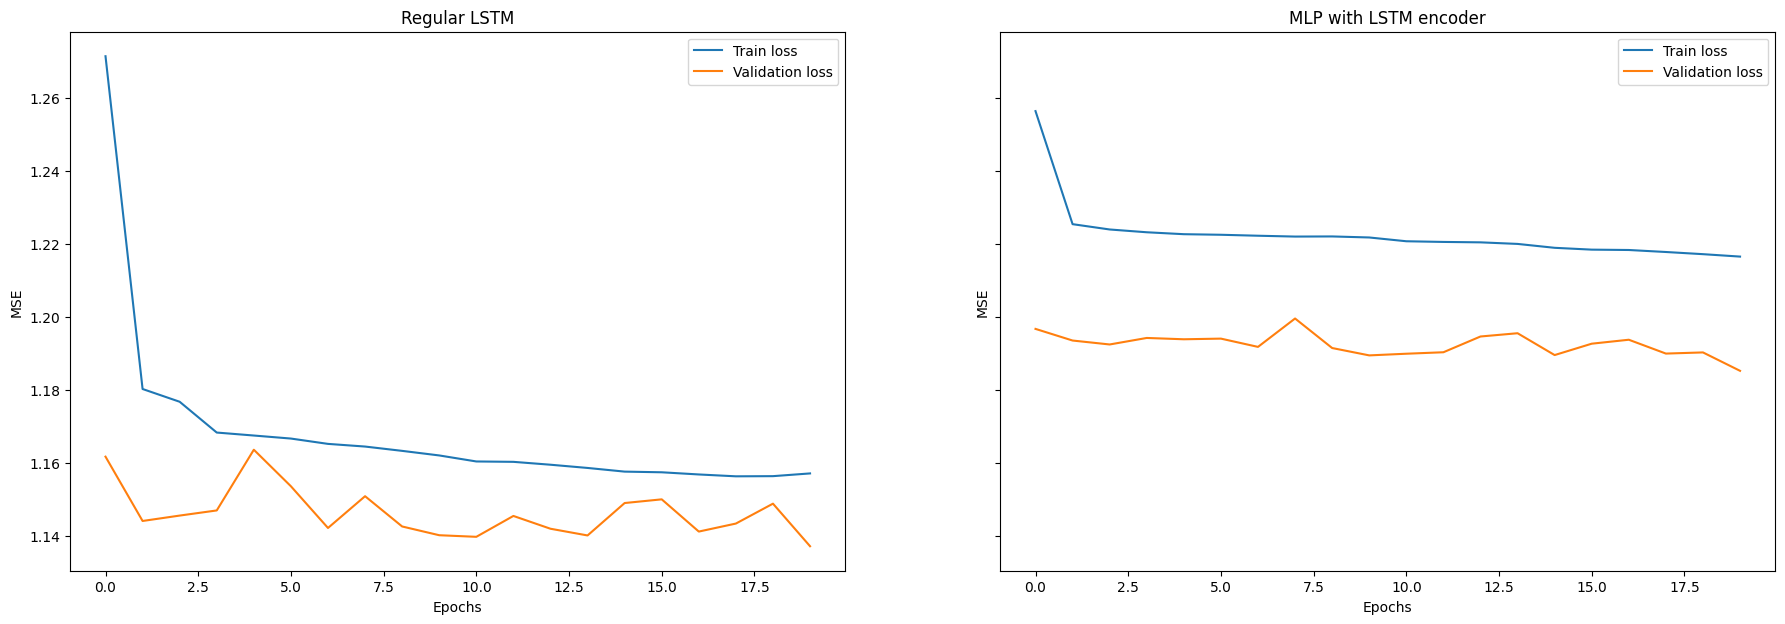

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22, 7))

ax1.plot(lstm_history.history["loss"], label='Train loss')
ax1.plot(lstm_history.history["val_loss"], label="Validation loss")
ax1.legend(loc="best")
ax1.set_title("Regular LSTM")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE")

ax2.plot(mlp_history.history["loss"], label="Train loss")
ax2.plot(mlp_history.history["val_loss"], label="Validation loss")
ax2.legend(loc="best")
ax2.set_title("MLP with LSTM encoder")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("MSE")

plt.show()

**Regular LSTM on train and validation**